In [23]:
import numpy as np
import pandas as pd
from random import sample
import requests
from PIL import Image, ImageColor
from sklearn.cluster import KMeans, MiniBatchKMeans
from matplotlib import pyplot as plt

In [24]:
def online_image_loader(url):

    """
    Load an image from a given URL.

    Args:
    
        url: A string representing the URL of the image to be loaded.

    Returns:
        An Image object representing the loaded image.

    Raises:
        Exception: If the image could not be loaded from the given URL.

    Example:
        >>> image = online_image_loader('https://example.com/image.jpg')
    """
    
    response = requests.get(url, stream=True).raw
    try:
        image = Image.open(response)
        bands = list(image.getbands())
    except:
        raise Exception('Image not found, try another URL')  
    return image, bands

In [25]:
def local_image_loader(path):
    
    """
    Load an image from a given file path.

    Args:
        path: A string representing the file path of the image to be loaded.

    Returns:
        An Image object representing the loaded image.

    Raises:
        Exception: If the image could not be loaded from the given file path.

    Example:
        >>> image = local_image_loader('/path/to/image.jpg')
    """

    try:
        image = Image.open(path)
        bands = list(image.getbands())
    except:
        raise Exception('Image not found, try another path')
    return image, bands

In [26]:
def flatten_image(image):

    """
    Flatten an image into a pandas DataFrame.

    Args:
        image: An Image object representing the image to be flattened.

    Returns:
        A pandas DataFrame representing the flattened image. Each column in the
        DataFrame represents a color channel of the image.

    Example:
        >>> image = Image.open('/path/to/image.jpg')
        >>> flattened_image = flatten_image(image)
    """
    
    df = pd.DataFrame(list(image.getdata()),columns=list(image.getbands()))
    return df

In [27]:
class Clusterer():
    
    """
    A class for clustering RGB color values using different clustering algorithms.

    Attributes:
        df: A pandas DataFrame containing the RGB values of each color to be clustered.
        models: A dictionary storing the clustering models created by the class methods.

    Methods:
        KM: Create a KMeans clustering model and store it in the models dictionary.
        MBKM: Create a MiniBatchKMeans clustering model and store it in the models dictionary.

    Example:
        >>> clusterer = Clusterer(df)
        >>> km_model = clusterer.KM()
        >>> mbkm_model = clusterer.MBKM()
    """

    def __init__(self, df):

        """
        Initialize a new Clusterer object.

        Args:
            df: A pandas DataFrame containing the RGB values of each color to be clustered.
        """

        self.df = df
        self.models = {}

    def kmeans_model(self,colors):

        """
        Create a KMeans clustering model and store it in the models dictionary.

        Args:
            colors: The number of colors to be clustered.

        Returns:
            The KMeans clustering model.

        Example:
            >>> km_model = clusterer.KM()
        """

        self.models['KMeans'] = KMeans(n_clusters=colors,n_init='auto').fit(self.df)
        return self.models['KMeans']
    
    def minibatchkmeans_model(self,colors):

        """
        Create a MiniBatchKMeans clustering model and store it in the models dictionary.

        Args:
            colors: The number of colors to be clustered.

        Returns:
            The MiniBatchKMeans clustering model.

        Example:
            >>> mbkm_model = clusterer.MBKM()
        """

        self.models['MiniBatchKMeans'] = MiniBatchKMeans(n_clusters=colors,n_init='auto').fit(self.df)
        return self.models['MiniBatchKMeans']
        
    
    


In [28]:
def generate_rgb_palette(model,colors,norm=False):
    
    """
    Generate a list of RGB color tuples based on the cluster centers of a given model.

    Args:
        model: A clustering model with a `cluster_centers_` attribute containing
            the RGB values of the cluster centers. This should be a NumPy array
            with shape (n_clusters, 3).
        norm (bool): Whether to normalize the RGB values to the range [0, 1] by
            dividing each value by 255. Default is False.
        colors (int): Number of colors to be generated.

    Returns:
        A list of RGB color tuples. Each tuple has three integers between 0 and 255
        representing the red, green, and blue components of the color.

    Example:
        >>> from sklearn.cluster import KMeans
        >>> model = KMeans(n_clusters=5, random_state=0).fit(X)
        >>> generate_rgb_palette(model)
        [(255, 51, 0), (51, 153, 255), (255, 204, 0), (0, 102, 51), (255, 153, 204)]
    """
    
    centers = model.cluster_centers_.astype(int)
    luminance = [0.2126*r + 0.7152*g + 0.0722*b for r, g, b in centers]
    sorted_indices = np.argsort(luminance)
    centers_sorted = centers[sorted_indices]

    if norm:
        palette = centers_sorted[:colors] / 255.0
    else:
        palette = centers_sorted[:colors].round().astype(int)
    
    palette_tuple = [tuple(p) for p in palette]
    return palette_tuple


In [29]:
def rgb_to_hex(rgb_value):

    """
    Convert an RGB color tuple to its hexadecimal representation.

    Args:
        rgb_value (tuple): A tuple containing three integers between 0 and 255
            representing the red, green, and blue components of a color.

    Returns:
        A string containing the hexadecimal representation of the color. The
        string will start with a '#' character followed by six hexadecimal digits
        representing the red, green, and blue components of the color.

    Example:
        >>> rgb_to_hex((255, 0, 0))
        '#ff0000'
        >>> rgb_to_hex((0, 128, 255))
        '#0080ff'
    """
    r, g, b = rgb_value[0], rgb_value[1], rgb_value[2]
    return '#{:02x}{:02x}{:02x}'.format(r, g, b)

In [30]:
def generate_hex_palette(model, colors):

    """
    Generate a list of hexadecimal color codes based on the cluster centers of a given model.

    Args:
        model: A clustering model with a `cluster_centers_` attribute containing
            the RGB values of the cluster centers. This should be a NumPy array
            with shape (n_clusters, 3).
        colors: The number of colors to be clustered.

    Returns:
        A list of hexadecimal color codes. Each code is a string representing a
        6-digit hexadecimal number in the format "#RRGGBB", where RR, GG, and BB
        are two-digit hexadecimal numbers representing the red, green, and blue
        components of the color.

    Example:
        >>> from sklearn.cluster import KMeans
        >>> model = KMeans(n_clusters=5, random_state=0).fit(X)
        >>> generate_hex_palette(model)
        ['#ff3300', '#3399ff', '#ffcc00', '#006633', '#ff99cc']
    """
    
    centers = model.cluster_centers_.astype(int)
    luminance = [0.2126*r + 0.7152*g + 0.0722*b for r, g, b in centers]
    sorted_indices = np.argsort(luminance)
    centers_sorted = centers[sorted_indices]
    palette = centers_sorted[:colors].round().astype(int)
    palette = [rgb_to_hex(p) for p in palette]
    return palette

In [31]:
def hex_to_rgb(hex_value):

    """
    Convert a hexadecimal color code to an RGB color tuple.

    Args:
        hex_value: A string representing a 6-digit hexadecimal number in the
            format "#RRGGBB", where RR, GG, and BB are two-digit hexadecimal
            numbers representing the red, green, and blue components of the color.

    Returns:
        A tuple of three floats between 0 and 1 representing the red, green, and
        blue components of the color.

    Example:
        >>> hex_to_rgb('#ff3300')
        (1.0, 0.2, 0.0)
    """

    h = hex_value.lstrip('#')
    return tuple(int(h[i:i + 2], 16) / 255.0 for i in (0, 2, 4))

In [32]:
def ensemble_palettes(models,colors):

    """ 
    Generate a palette of colors by averaging the cluster centers of multiple models.

    Args:
        models: A list of clustering models with a `cluster_centers_` attribute containing
        the RGB values of the cluster centers. This should be a NumPy array
        colors: The number of colors to be clustered.

    Returns:
        A list of RGB color tuples and a list of hexadecimal color codes.
    """
    
    rgb_palette = np.mean([generate_rgb_palette(model,colors) for model in models], axis=0).astype(int)
    hex_palette = [rgb_to_hex(p) for p in rgb_palette]
    rgb_palette = [tuple(p) for p in rgb_palette]
    return rgb_palette, hex_palette

In [33]:
def segmented_palette(image, colors):
    """
    Given an input `image` PIL object and a desired number of `colors`,
    this function generates a segmented palette by dividing the image into
    `colors` segments and extracting the top color from each segment using
    two clustering models. The function returns a dictionary with two keys,
    'rgb_palette' and 'hex_palette', each of which contains a list of length
    `colors` representing the dominant colors in each segment in RGB and HEX
    formats, respectively. Additionally, the function returns a list of PIL
    images, where each image represents one segment of the input `image`.
    
    Parameters
    ----------
    image : PIL.Image object
        The input image to extract the segmented palette from.
    colors : int
        The desired number of colors in the segmented palette.
    
    Returns
    -------
    dict, list
        A dictionary with two keys, 'rgb_palette' and 'hex_palette', each
        containing a list of length `colors` representing the dominant colors
        in each segment in RGB and HEX formats, respectively. Additionally,
        a list of PIL images, where each image represents one segment of the
        input `image`.
    """

    h, w = np.asarray(image).shape[:2]
    segment_length = w//colors
    
    top = 0
    bottom = h
    left = 0
    right = segment_length

    image_segments = []
    for i in range(colors):
        image_segments.append(image.crop((left, top, right, bottom)))
        left += segment_length
        right += segment_length

    segment_palette = {
        'rgb_palette': [],
        'hex_palette': []
    }

    for segment in image_segments:
        segment = flatten_image(segment)
        models = [Clusterer(segment).KM(1), Clusterer(segment).MBKM(1)]
        rgb_palette, hex_palette = ensemble_palettes(models,colors)
        segment_palette['rgb_palette'].append(rgb_palette[0])
        segment_palette['hex_palette'].append(hex_palette[0])
        
    return segment_palette, image_segments
    

In [34]:
def plot_segments(image_segments):
    """Plots a list of image segments as subplots in a single figure.

    Args:
        image_segments (List[PIL.Image]): A list of image segments represented as NumPy arrays.

    Returns:
        None
    """

    n_segments = len(image_segments)

    h, w = n_segments*np.array(image_segments[0]).shape[0],n_segments*np.array(image_segments[0]).shape[1]
    
    px = 1/plt.rcParams['figure.dpi']

    fig, axes = plt.subplots(nrows=1, ncols=len(image_segments), figsize=(w*px,h*px))

    for i, ax in enumerate(axes):
        ax.imshow(image_segments[i])
        ax.set_axis_off()
        
    plt.tight_layout()
    plt.show()

In [35]:
def visualize_palette_on_image(palette, image, colors, mode='RGB',reversed=False):

    """
    Visualizes the given color palette on top of the input image.

    Args:
    ----------
    - palette (list of tuples or list of strings): a list of colors in RGB tuples (0-255) or hex string format (#RRGGBB)
    - image (PIL.Image): the input image to which the palette will be applied
    - mode (str, optional): the color mode of the palette, either 'RGB' or 'HEX'. Default is 'RGB'.
    - reversed (bool): If True, the palette will be reversed. Default is False.
    - colors: The number of colors to be clustered.

    Returns:
    ----------
    - new_image (PIL.Image): a new image with the given color palette stacked on top of the input image

    Raises:
    ----------
    - AssertionError: if the width and height of the palette image and the input image do not match
    - ValueError: if the mode is not 'RGB' or 'HEX'
    """
    if reversed:
        palette = palette[::-1]

    if mode not in ['RGB', 'HEX']:
        raise ValueError("mode must be either 'RGB' or 'HEX'")
    
    new_width, _ = image.size
    size = (len(palette), 1)
    palette_img = Image.new('RGB', size, color='white')
    
    pixels = palette_img.load()
    for i in range(len(palette)):
        if mode == 'RGB':
            pixels[i, 0] = palette[i]
        elif mode == 'HEX':
            pixels[i, 0] = ImageColor.getrgb(palette[i])
    
    palette_image = np.asarray(palette_img.resize((new_width, int(new_width/colors)), 
                                                resample= Image.Resampling.NEAREST))
    image = np.asarray(image)

    assert palette_image.shape[1] == image.shape[1], "Image dimension mismatch"
    assert palette_image.shape[2] == image.shape[2], "Image dimension mismatch"
    concat_image = np.concatenate((image,palette_image), axis=0)
    new_image = Image.fromarray(concat_image)
    
    return new_image

In [36]:
def visualize_palette(palette, colors, mode='RGB',reversed=False):

    """ 
    Takes in a list of RGB tuples or HEX strings representing a color palette, 
    and returns an image object that visualizes the palette.

    Args:
    ----------
    - palette (list): A list of RGB tuples or HEX strings representing the colors in the palette.
    - mode (str): The mode in which to interpret the color values. Valid values are 'RGB' and 'HEX'. Default is 'RGB'.
    - reversed (bool): If True, the palette will be reversed. Default is False.
    - colors: The number of colors to be clustered.
    
    Returns:
    ----------
    palette_image (PIL.Image.Image): An image object that visualizes the color palette, with each color in the palette represented by a single pixel. 
    The image has a width of 1024 pixels and a height of 128 pixels (i.e. 8 pixels tall, with each color being represented by a row of 128 pixels). 
    If mode is 'RGB', the color values are interpreted as RGB tuples. If mode is 'HEX', the color values are interpreted as HEX strings. 

    Raises:
    ----------
    - ValueError: if the mode is not 'RGB' or 'HEX'
    """
    if reversed:
        palette = palette[::-1]

    if mode not in ['RGB', 'HEX']:
        raise ValueError("mode must be either 'RGB' or 'HEX'")
    
    size = (len(palette), 1)
    palette_img = Image.new('RGB', size, color='white')
    
    pixels = palette_img.load()
    
    for i in range(len(palette)):
        if mode == 'RGB':
            pixels[i, 0] = palette[i]
        elif mode == 'HEX':
            pixels[i, 0] = ImageColor.getrgb(palette[i])
    
    palette_image = palette_img.resize((1024, int(1024/N_COLORS)), resample= Image.Resampling.NEAREST)
    
    return palette_image

In [37]:
def random_sampled_palette(image,total=36,colors=8):

    """ 
    Generates a random palette from an image.

    Args:
    ----------
    - image (PIL Image): Input image
    - total (int): Number of colors to be clustered
    - colors (int): Number of colors to be sampled
    
    Returns:
    ----------
    - rgb_palette (list): List of sampled RGB tuples 
    - hex_palette (list): List of sampled HEX strings
    - rand_pal (PIL Image): Visualized sampled palette
    """
    
    image_flat = flatten_image(image)
    models = [Clusterer(image_flat).KM(total), Clusterer(image_flat).MBKM(total)]
    rgb_palette, hex_palette = ensemble_palettes(models,total)
    rgb_palette = sample(rgb_palette,colors)
    hex_palette = sample(hex_palette,colors)
    rand_pal = visualize_palette_on_image(hex_palette, image, colors=colors, mode='HEX')
    return rgb_palette, hex_palette, rand_pal

In [38]:
def sized_palettes(image):
    """ 
    Testing Function: generates a vizualised palette on image at different sizes

    Args:
    ----------
    - image (PIL Image): Input image
    
    Returns:
    ----------
    - sizes (list): List of images with vizualised palettes at different sizes 
    """
    
    h, w = image.size
    sizes = []
    for i in np.arange(0.5,1,0.1):
        image = image.resize((int(h*i),int(w*i)))
        models = [Clusterer(flatten_image(image)).KM(8), Clusterer(flatten_image(image)).MBKM(8)]
        _, hex_palette = ensemble_palettes(models,8)
        sizes.append(visualize_palette_on_image(hex_palette, image, colors=8, mode='HEX'))
    return sizes
        
        

In [39]:
# Testing Cell
N_COLORS = 12
url = input('Enter image url: ')
img_online, bands = online_image_loader(url)
flat_online = flatten_image(img_online)
models = [Clusterer(flat_online).KM(N_COLORS), Clusterer(flat_online).MBKM(N_COLORS)]


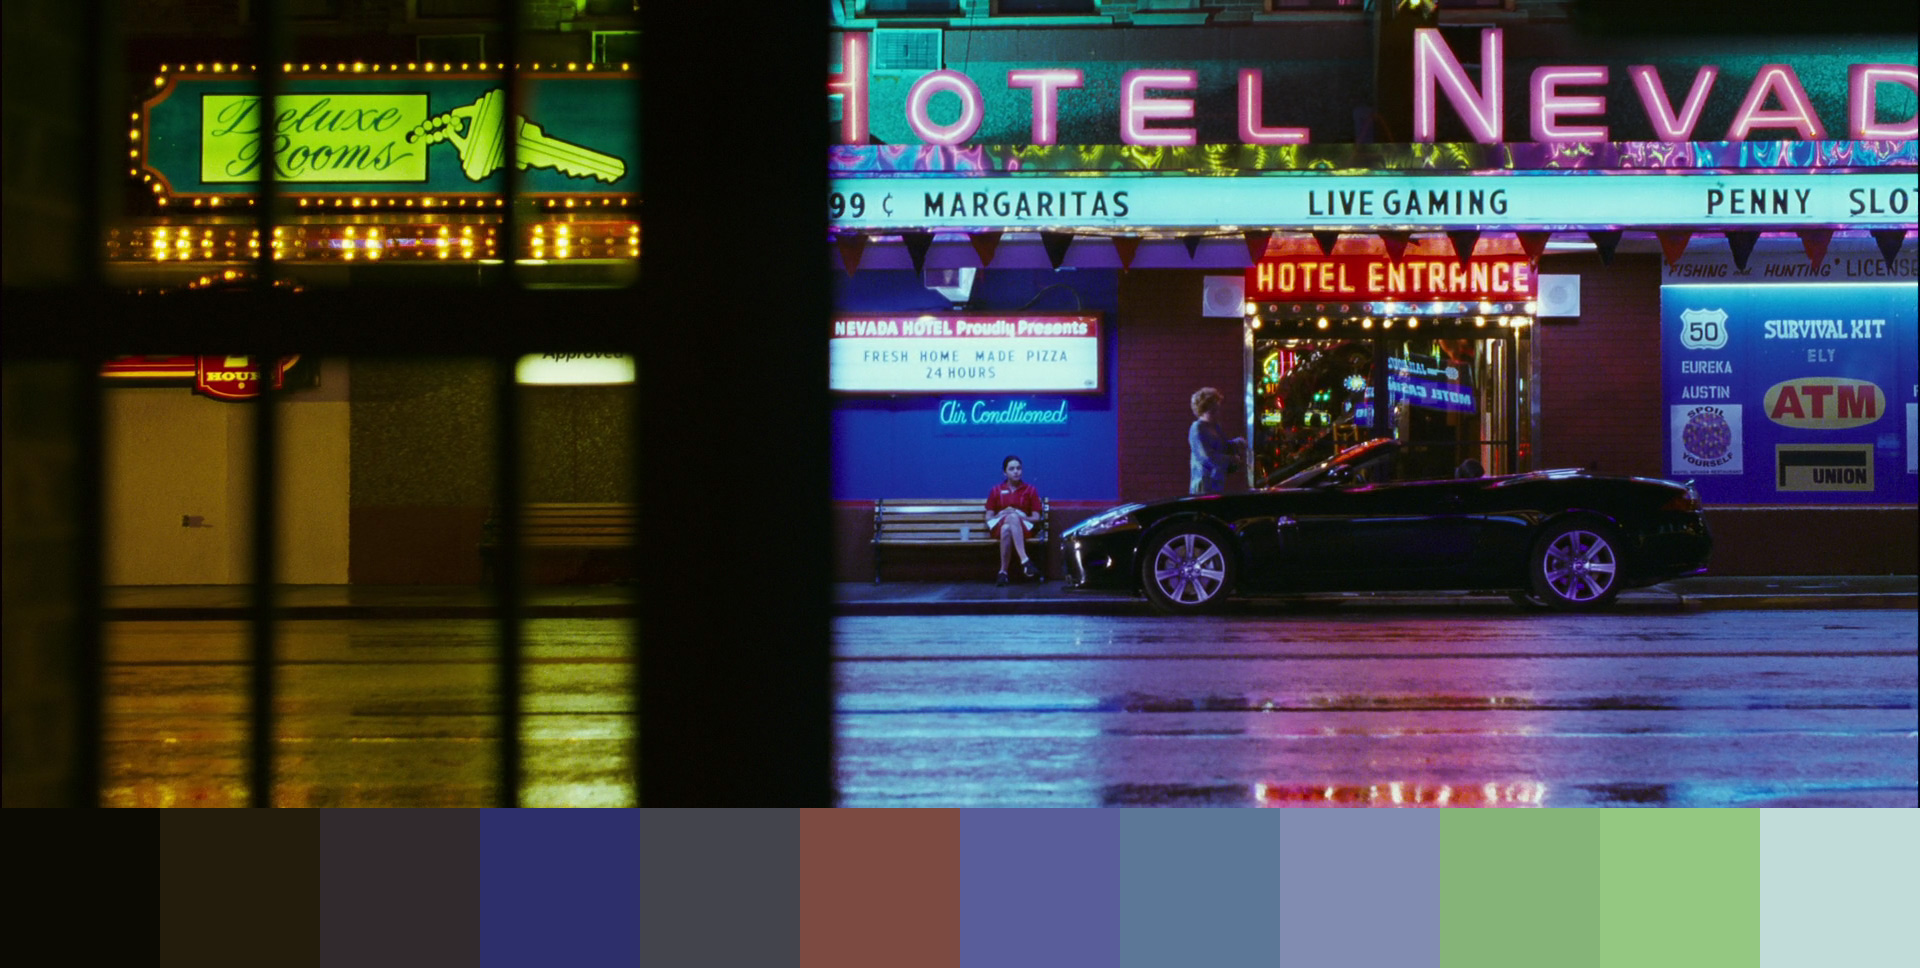

In [41]:
rgb_palette, hex_palette = ensemble_palettes(models,N_COLORS)
segment_palette, image_segments = segmented_palette(img_online, N_COLORS)
pal_image = visualize_palette_on_image(hex_palette, img_online, colors=N_COLORS, mode='HEX')
display(pal_image)
# plot_segments(image_segments)
